# "Segmentez des clients d'un site e-commerce"
_Cleaning Notebook_

## 0 Preliminaries

In [1]:
# !pip install flake8 pycodestyle_magic
# !pip install gtts
# !pip install category-encoders
# !pip install mlxtend==0.17.3 # makes Google Colab asking for reboot
# !pip install ppscore

In [2]:
# !pip freeze > requirements_cleaning_eda.txt

Checking for PEP8 compliance

In [3]:
# %load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [4]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on colab

In [5]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
You're on Google Colab


Installations and importations required in the virtual environment.

In [6]:
import os
if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS':
        os.chdir('My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS')
else:
    if not (os.path.exists(os.getcwd()+'/requirements_cleaning_eda.txt') \
                     and os.path.exists(os.getcwd()+'/P5_functions.py')):
        print("ERROR: Make sure 'P5_functions.py' and 'requirements_cleaning_eda.txt' are in the current working directory")

!pip install -r requirements_cleaning_eda.txt
from P5_functions import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importation of modules and packages. 

In [7]:
import io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

Setting pandas display options

In [8]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 100,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

To play audio text-to-speech during execution.

In [9]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [10]:
speak('Packages and modules successfully imported')

### 0.1 Importing the Aggregated Orders dataset

Let's load the dataframe of aggregated orders as well as the dataframe of aggregated customers.

This way, we'll be able to reconstruct the dataframe of customer on different slots of time later on.

In [11]:
if is_colab==True:
    # Importing database from my Drive
    print("Try to import data files in the notebook from myDrive...")
else:
    # Importing database from PC
    print("Try to import data files in the notebook from PC ('DATA')...")

df_cust = pd.read_csv('agg_customers.csv', sep=',', index_col='customer_unique_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

df_orders = pd.read_csv('agg_orders.csv', sep=',', index_col='order_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

print("-----> Importation of .csv in the notebook: OK")

Try to import data files in the notebook from myDrive...
-----> Importation of .csv in the notebook: OK


All the dates and timestamps in the dataframes are to be converted.

In [12]:
# Dates are converted in datetime format, and timedeltas in timedeltas
df_orders[['order_purchase_timestamp', 'max_limit_ship_date']] = \
    df_orders[['order_purchase_timestamp', 'max_limit_ship_date']]\
        .apply(lambda x: pd.to_datetime(x))
df_orders[['shipping_time', 'shipping_delay']] = \
    df_orders[['shipping_time', 'shipping_delay']]\
        .apply(lambda x: pd.to_timedelta(x))  
df_orders['customer_zip_code_prefix'] = \
    df_orders['customer_zip_code_prefix'].astype('object')

# Time in df_cust are already encoded in days (int)
df_cust['cust_zipcode'] = \
    df_cust['cust_zipcode'].astype('object')

In [13]:
df_orders.shape, df_cust.shape

((99440, 38), (96095, 45))

In [14]:
df_orders.columns, df_cust.columns

(Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state',
        'order_status', 'order_purchase_timestamp', 'shipping_time', 'shipping_delay', 'delivered',
        'price', 'freight_value', 'order_item_nb', 'max_limit_ship_date', 'mean_prod_descr_length',
        'review_score', 'review_comment_length', 'cum_paytype', 'paytype_boleto',
        'paytype_credit_card', 'paytype_debit_card', 'paytype_not_defined', 'paytype_voucher',
        'payment_installments', 'payment_value', 'main_prod_categ', 'cat_office', 'cat_unknown',
        'cat_fashion', 'cat_furniture', 'cat_hygiene', 'cat_home', 'cat_leisure', 'cat_diy',
        'cat_multimedia', 'cat_food', 'cat_electronics', 'cat_books', 'cat_miscellaneous'],
       dtype='object'),
 Index(['cust_zipcode', 'cust_city', 'cust_state', 'mean_nb_items_per_ord', 'tot_nb_items',
        'mean_freight_val_per_order', 'tot_freight_val', 'mean_price_per_order',
        'avg_freight_payval_ratio', 'tot_price', 't

In [15]:
df_orders.dtypes.value_counts()

float64            20
int64               7
object              7
datetime64[ns]      2
timedelta64[ns]     2
dtype: int64

In [16]:
df_cust.dtypes.value_counts()

float64    27
int64      13
object      5
dtype: int64

In [17]:
speak('Dataset successfully imported')

### 0.2 Aggregation of the customers dataset on custom time slots 

If we need to recompute the dataset in another period of time, we just need to call the function below, indicating as argument the right t_min and t_max.

In [18]:
# Aggregation in a chosen time slot
# all customers (for max period of time): (96095, 22)

# t_min = pd.Timestamp('2017-10-17 17:30:18')
# t_max = pd.Timestamp('2018-01-01 17:30:18')

def generate_cust_df(df_orders, t_min=None, t_max=None):
    df_cust = create_agg_cust_df(df_orders, t_min=t_min, t_max=t_max)
    df_cust = create_features_cust_df(df_cust)
    return df_cust

# test_df_cust = generate_cust_df(df_orders, t_min=None, t_max=None)

In [19]:
df_cust.shape

(96095, 45)

## 1 Clustering

### 1.1 Data preprocessing

In [20]:
df_cust.columns

Index(['cust_zipcode', 'cust_city', 'cust_state', 'mean_nb_items_per_ord', 'tot_nb_items',
       'mean_freight_val_per_order', 'tot_freight_val', 'mean_price_per_order',
       'avg_freight_payval_ratio', 'tot_price', 'tot_nb_deliv_ord', 'tot_nb_ord', 'single_purch',
       'nb_not_rec_orders', 'mean_ship_delay', 'time_since_first_purch', 'mean_ship_time',
       'time_since_last_purch', 'mean_rev_score', 'tot_comment_length', 'mean_comment_length',
       'mean_prod_descr_length', 'main_prod_categ', 'mean_pay_value_per_order',
       'paytype_voucher_tot_nb', 'tot_pay_value', 'paytype_not_defined_tot_nb', 'mean_pay_install',
       'paytype_debit_card_tot_nb', 'paytype_boleto_tot_nb', 'cum_paytype',
       'paytype_credit_card_tot_nb', 'cat_multimedia_tot_nb', 'cat_unknown_tot_nb',
       'cat_miscellaneous_tot_nb', 'cat_fashion_tot_nb', 'cat_leisure_tot_nb', 'cat_food_tot_nb',
       'cat_electronics_tot_nb', 'cat_books_tot_nb', 'cat_diy_tot_nb', 'cat_home_tot_nb',
       'cat_hygie

In [21]:
df_cust.head(3)

,cust_zipcode,cust_city,cust_state,mean_nb_items_per_ord,tot_nb_items,mean_freight_val_per_order,tot_freight_val,mean_price_per_order,avg_freight_payval_ratio,tot_price,tot_nb_deliv_ord,tot_nb_ord,single_purch,nb_not_rec_orders,mean_ship_delay,time_since_first_purch,mean_ship_time,time_since_last_purch,mean_rev_score,tot_comment_length,mean_comment_length,mean_prod_descr_length,main_prod_categ,mean_pay_value_per_order,paytype_voucher_tot_nb,tot_pay_value,paytype_not_defined_tot_nb,mean_pay_install,paytype_debit_card_tot_nb,paytype_boleto_tot_nb,cum_paytype,paytype_credit_card_tot_nb,cat_multimedia_tot_nb,cat_unknown_tot_nb,cat_miscellaneous_tot_nb,cat_fashion_tot_nb,cat_leisure_tot_nb,cat_food_tot_nb,cat_electronics_tot_nb,cat_books_tot_nb,cat_diy_tot_nb,cat_home_tot_nb,cat_hygiene_tot_nb,cat_office_tot_nb,cat_furniture_tot_nb
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,7787,cajamar,SP,1.00,1.00,12.00,12.00,129.90,0.08,129.90,1,1,1,0,6,160,6,160,5.00,111.00,111.00,236.00,bed_bath_table,141.90,0,141.90,0,8.00,0,0,C,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
0000b849f77a49e4a4ce2b2a4ca5be3f,6053,osasco,SP,1.00,1.00,8.29,8.29,18.90,0.30,18.90,1,1,1,0,3,163,3,163,4.00,0.00,0.00,635.00,health_beauty,27.19,0,27.19,0,1.00,0,0,C,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
0000f46a3911fa3c0805444483337064,88115,sao jose,SC,1.00,1.00,17.22,17.22,69.00,0.20,69.00,1,1,1,0,25,585,25,585,3.00,0.00,0.00,177.00,stationery,86.22,0,86.22,0,8.00,0,0,C,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [22]:
df_cust.select_dtypes(include=['object']).nunique()

cust_zipcode       14981
cust_city           4119
cust_state            27
main_prod_categ       74
cum_paytype            7
dtype: int64

Here we use a custom transformer (see the class CustTransformer in P5_functions.py) to:
- encode categorical data with Ordinal Encoder
- Standardize the quantitative data with StandardScaler

In [23]:
# Transformation and encoding
ct = CustTransformer(strat_high_card='ord', # Ordinal encoding for categorical data
                     strat_quant='stand') # Standardization for quantitative data
ct.fit(df_cust)
df_cust_trans = ct.transform(df_cust)

In [24]:
df_cust_trans.columns

Index(['binary__single_purch', 'binary__paytype_not_defined_tot_nb', 'low_card__cum_paytype_1',
       'low_card__cum_paytype_2', 'low_card__cum_paytype_3', 'low_card__cum_paytype_4',
       'low_card__cum_paytype_5', 'low_card__cum_paytype_6', 'low_card__cum_paytype_7',
       'high_card__cust_zipcode', 'high_card__cust_city', 'high_card__cust_state',
       'high_card__main_prod_categ', 'mean_nb_items_per_ord', 'tot_nb_items',
       'mean_freight_val_per_order', 'tot_freight_val', 'mean_price_per_order',
       'avg_freight_payval_ratio', 'tot_price', 'tot_nb_deliv_ord', 'tot_nb_ord',
       'nb_not_rec_orders', 'mean_ship_delay', 'time_since_first_purch', 'mean_ship_time',
       'time_since_last_purch', 'mean_rev_score', 'tot_comment_length', 'mean_comment_length',
       'mean_prod_descr_length', 'mean_pay_value_per_order', 'paytype_voucher_tot_nb',
       'tot_pay_value', 'mean_pay_install', 'paytype_debit_card_tot_nb', 'paytype_boleto_tot_nb',
       'paytype_credit_card_tot_nb

### 1.2 KMeans clustering

In [25]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=5)
km.fit(df_cust_trans)
clust = pd.Series(data=km.labels_, index=df_cust.index)

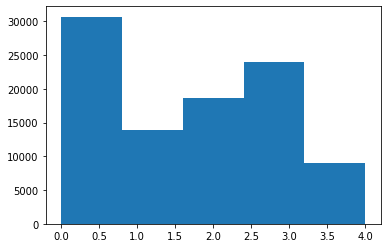

In [26]:
# Number of customers in each clusters
plt.hist(clust, bins=5);

In [27]:
# Silhouette coefficient
from sklearn.metrics import silhouette_score
silh = silhouette_score(df_cust_trans, clust)
print("Silhouette Coefficient: {:.3f}".format(silh))

Silhouette Coefficient: 0.490


#### Representation of customers of the clusters on the first axis of a PCA

In [84]:
df_cust_trans.columns

Index(['binary__single_purch', 'binary__paytype_not_defined_tot_nb', 'low_card__cum_paytype_1',
       'low_card__cum_paytype_2', 'low_card__cum_paytype_3', 'low_card__cum_paytype_4',
       'low_card__cum_paytype_5', 'low_card__cum_paytype_6', 'low_card__cum_paytype_7',
       'high_card__cust_zipcode', 'high_card__cust_city', 'high_card__cust_state',
       'high_card__main_prod_categ', 'mean_nb_items_per_ord', 'tot_nb_items',
       'mean_freight_val_per_order', 'tot_freight_val', 'mean_price_per_order',
       'avg_freight_payval_ratio', 'tot_price', 'tot_nb_deliv_ord', 'tot_nb_ord',
       'nb_not_rec_orders', 'mean_ship_delay', 'time_since_first_purch', 'mean_ship_time',
       'time_since_last_purch', 'mean_rev_score', 'tot_comment_length', 'mean_comment_length',
       'mean_prod_descr_length', 'mean_pay_value_per_order', 'paytype_voucher_tot_nb',
       'tot_pay_value', 'mean_pay_install', 'paytype_debit_card_tot_nb', 'paytype_boleto_tot_nb',
       'paytype_credit_card_tot_nb

In [28]:
from sklearn.decomposition import PCA

exclude_cols = ['high_card__cust_zipcode','high_card__cust_city',
                'high_card__main_prod_categ','high_card__cust_state']

pca_cols = [c for c in df_cust_trans.columns if not c in exclude_cols]
pca_cols = [c for c in pca_cols if not (('cat_' in c) or ('paytype' in c))]
X = df_cust_trans.loc[:, pca_cols].values

n_comp = 10
pca = PCA(n_components=n_comp).fit(X)
pca_df = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=pca_cols).T
X_proj = pca.transform(X)

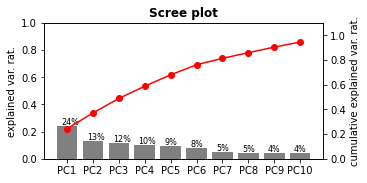

In [29]:
exp_var_rat = pca.explained_variance_ratio_
scree_plot(col_names=pca_df.columns,
           exp_var_rat=exp_var_rat,
           ylim=(0,1), figsize=(5,2.5))
plt.show()

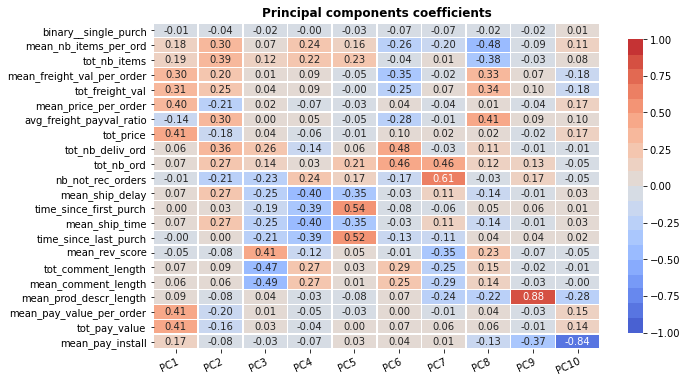

In [30]:
plot_heatmap(pca_df,'Principal components coefficients',
             vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("coolwarm", 20),
             figsize=(10,6),shape='rect')
plt.show()

We plot the projection of the observations on the fist axes of the PCA, indicating in different colors the different clusters.

2113

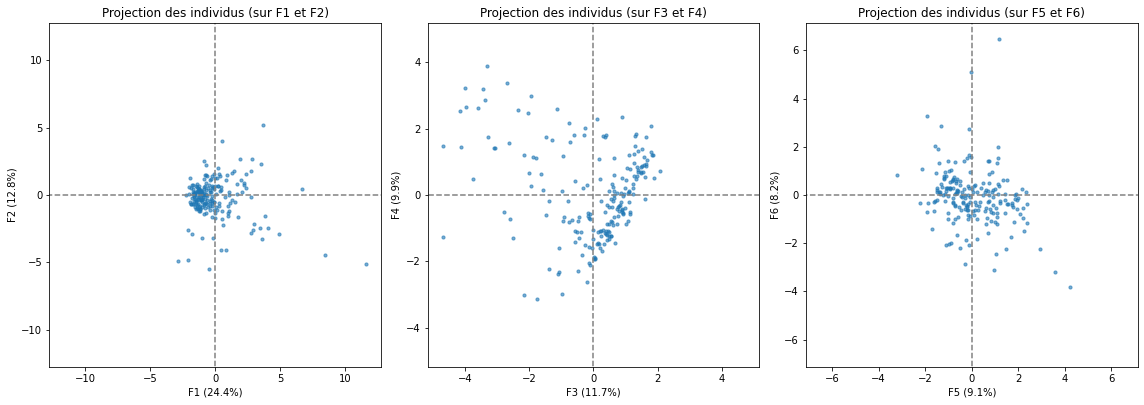

In [47]:

X_samp = df_cust_trans.loc[:, pca_cols].sample(200)
display_factorial_planes(pca.transform(X_samp.values), 10, pca, [(0,1),(2,3),(4,5)],
                         n_cols=3, labels=None,#np.array(id_code_samp),
                         illus_var=None,
                         lab_on=False, alpha=0.6)
plt.show()

NameError: ignored

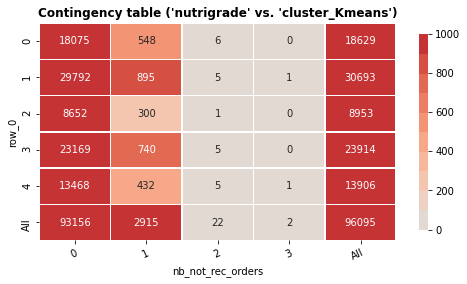

In [103]:
## Creating table of contingency

data_crosstab = pd.crosstab(clust, 
                            df_cust['nb_not_rec_orders'],  
                               margins = True)

plot_heatmap(data_crosstab,"Contingency table ('nutrigrade' vs. 'cluster_Kmeans')",
             vmin=0, vmax=1000, palette=sns.color_palette("coolwarm", 20),
             figsize=(8,4), shape='rect', fmt='.0f')
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_4_2_nutrig_clusters.png', dpi=400);
plt.show()

In [ ]:
# Contingency table showing cluster vs. pnns1 categories

data_crosstab = pd.crosstab(df['pnns1'], 
                            df['cluster_Kmeans'],  
                               margins = True)
# display(data_crosstab

# Chi-Squared Test
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(data_crosstab)
print('---'+"Chi-squared")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably independent') if p > 0.05 else print('Probably dependent')

pca_df = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=pca_cols).T
plot_heatmap(data_crosstab,"Contingency table ('clusters' vs. 'pnns1')",
             vmin=0, vmax=1000,figsize=(10,4),shape='rect', fmt='.0f',
             palette=sns.color_palette("coolwarm", 20))
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_4_2_cont_tabl_clust_pnns1.png',
                             dpi=400);
plt.show()

In [ ]:
# Hierarchical Clustering

# Z = linkage(X_sc, 'ward')
# print(Z[0:15])
# plt.figure(figsize=(16,10))
# dendrogram(Z, labels = df.index, orientation = "right", count_sort='descending')
# plt.show()

# n_clust = 6
# clustH = fcluster(Z, n_clust, criterion='maxclust')
# df['cluster_HierClust'] = clustH
# clustH